In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt

def get_spherical(x, y, z):
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return r, theta, phi

In [3]:
log_filename = "log018.csv"
df = pd.read_csv("logs/" + log_filename)
time = df["t_ms"].values
mag_raw = df[["mmc_mG_x", "mmc_mG_y", "mmc_mG_z"]].values
angle_raw = df["angle_raw"].values * np.pi * 2 / 4096
accel_proj = np.load(f"net_accel_projected_{log_filename}.npy")

slice_time = False

# Get a time slice
if slice_time:
    start_time = 20000  # ms
    end_time = 40000  # ms
    mask = (time >= start_time) & (time <= end_time)
    time = time[mask]
    mag_raw = mag_raw[mask]
    angle_raw = angle_raw[mask]
    accel_proj = accel_proj[mask]

In [4]:
# Get magnetometer data and filter and convert to spherical coordinates
fc_hz = 20
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")

mag_sp = np.array([get_spherical(x, y, z) for x, y, z in mag_raw])
mag_filtered = sosfiltfilt(sos, mag_raw, axis=0)
mag_filt_sp = np.array([get_spherical(x, y, z) for x, y, z in mag_filtered])

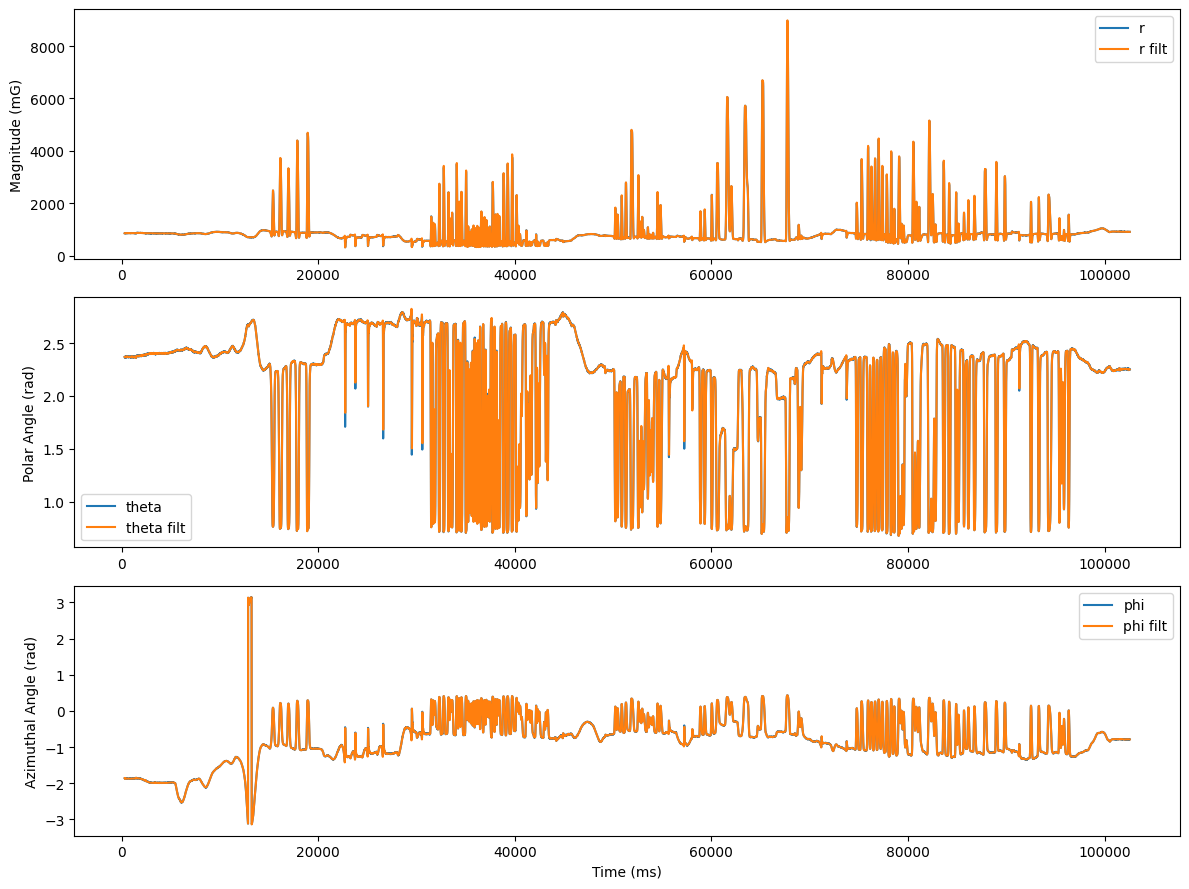

In [5]:
#Plot spherical coordinates
plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(time, mag_sp[:, 0], label="r")
plt.plot(time, mag_filt_sp[:, 0], label="r filt")
plt.ylabel("Magnitude (mG)")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(time, mag_sp[:, 1], label="theta")
plt.plot(time, mag_filt_sp[:, 1], label="theta filt")
plt.ylabel("Polar Angle (rad)")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(time, mag_sp[:, 2], label="phi")
plt.plot(time, mag_filt_sp[:, 2], label="phi filt")
plt.ylabel("Azimuthal Angle (rad)")
plt.xlabel("Time (ms)")
plt.legend()
plt.tight_layout()
plt.show()

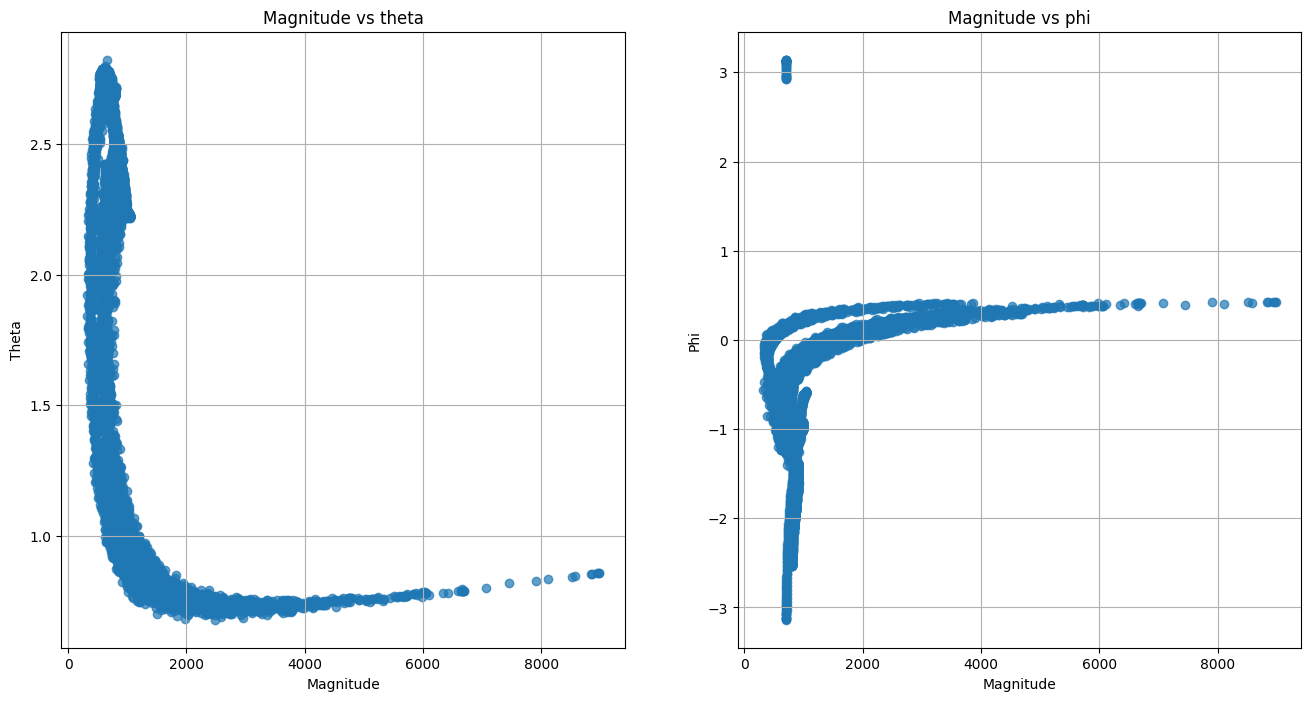

In [6]:
# Plot scatter of magnet angle vs magnitude
# Scatter plot of vectors
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(mag_filt_sp[:, 0], mag_filt_sp[:, 1], alpha=0.7)
plt.title("Magnitude vs theta")
plt.xlabel("Magnitude")
plt.ylabel("Theta")
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(mag_filt_sp[:, 0], mag_filt_sp[:, 2], alpha=0.7)
plt.title("Magnitude vs phi")
plt.xlabel("Magnitude")
plt.ylabel("Phi")
plt.grid()
plt.show()

In [7]:
# Get angle data and filter it
fc_hz = 20
fs = 100

angle_data = angle_raw# * 360 / 4096  # convert from raw to degrees
sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")
angle_filtered = sosfiltfilt(sos, angle_data)


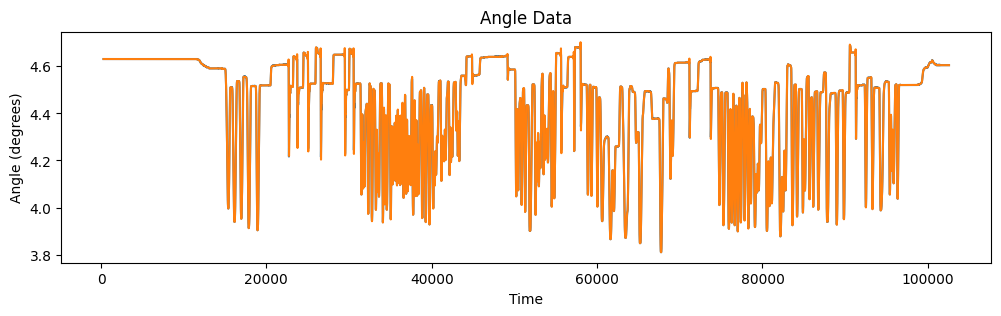

In [8]:
# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 3))
plt.plot(time, angle_data)
plt.plot(time, angle_filtered)
plt.title("Angle Data")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.show()

In [9]:
# Get corrected angle
hypotenuse = 120
top_adjacent = 237.5 / 2

top_angle = np.arccos(top_adjacent / hypotenuse)
print(top_angle)
top_zeroangle = np.percentile(angle_filtered, 95)
print(top_zeroangle)
net_angle = -1 * (angle_filtered - top_zeroangle) + top_angle

0.14446315489373626
4.644783495899473


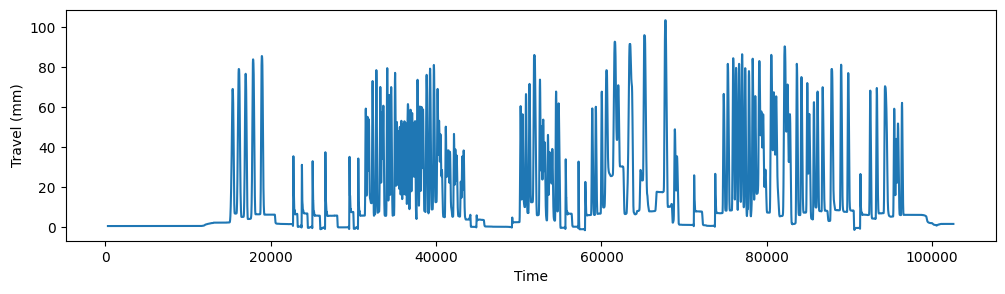

In [10]:
# Convert angle to travel and plot 
travel = 2 * (top_adjacent - (hypotenuse * np.cos(net_angle)))

# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 3))
plt.plot(time, travel)
plt.xlabel("Time")
plt.ylabel("Travel (mm)")
plt.show()

In [11]:
# Threshold magnet data and project along the direction of travel
mag_threshold = 3000  # mG
print(mag_filtered.shape)
mag_filtered_thresh = mag_filtered[np.linalg.norm(mag_filtered, axis=1) > mag_threshold]
mean_vector = np.mean(mag_filtered_thresh, axis=0)
print(mean_vector)
# Project mag data onto mean vector to get travel along that direction
mag_travel_vector = mean_vector / np.linalg.norm(mean_vector)
print(mag_travel_vector)
mag_proj = mag_filtered @ mag_travel_vector

(10226, 3)
[2720.56315989  924.81649878 3084.25572248]
[0.64539061 0.2193913  0.73166825]


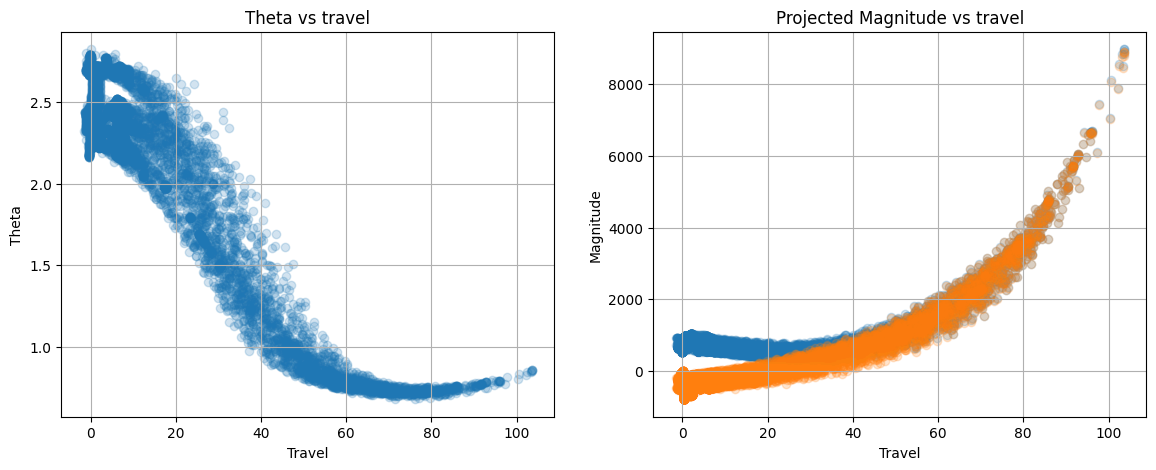

In [12]:
# Plot scatter of magnet data vs travel
# Scatter plot of vectors
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(travel, mag_filt_sp[:, 1], alpha=0.2)
plt.title("Theta vs travel")
plt.xlabel("Travel")
plt.ylabel("Theta")
plt.grid()
# Plot scatter of projected mag vs travel
plt.subplot(1, 2, 2)
plt.scatter(travel, mag_filt_sp[:, 0], alpha=0.2)
plt.scatter(travel, mag_proj, alpha=0.2)
plt.title("Projected Magnitude vs travel")
plt.xlabel("Travel")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

(579,)
[ 0.00000000e+00  1.71701924e-02 -1.81354074e-06  8.10892033e-11] 37.81354759749472
RMSE: 23.625224496836918
RMSE (points over 1000): 3.4870816309168116
RMSE (points over 2000): 2.4635120689881473
RMSE (points over 3000): 1.7948353771392775


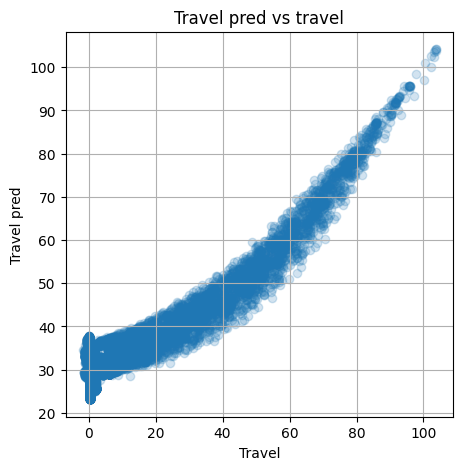

In [13]:
# Fit polynomial to get travel from projected mag
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_xy_by_xmin(x, y, xmin):
    x_mask = x > xmin
    xmasked = x[x_mask]
    ymasked = y[x_mask]
    return xmasked, ymasked

min_mag = 2000
mag_m, travel_m = get_xy_by_xmin(mag_proj, travel, min_mag)
print(mag_m.shape)

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(mag_m.reshape(-1, 1))
model = LinearRegression()
model.fit(X_poly, travel_m)
mag_poly = poly.fit_transform(mag_proj.reshape(-1, 1))
travel_pred = model.predict(mag_poly)
print(model.coef_, model.intercept_)

error = np.mean((travel - travel_pred) ** 2) ** 0.5
print(f"RMSE: {error}")

for mask_thresh in [1000, 2000, 3000]:
    min_mag_mask = mag_proj > mask_thresh
    masked_travel = travel[min_mag_mask]
    masked_travel_pred = travel_pred[min_mag_mask]
    error_masked = np.mean((masked_travel - masked_travel_pred) ** 2) ** 0.5
    print(f"RMSE (points over {mask_thresh}): {error_masked}")

plt.figure(figsize=(5, 5))
plt.scatter(travel, travel_pred, alpha=0.2)
plt.title("Travel pred vs travel")
plt.xlabel("Travel")
plt.ylabel("Travel pred")
plt.grid()

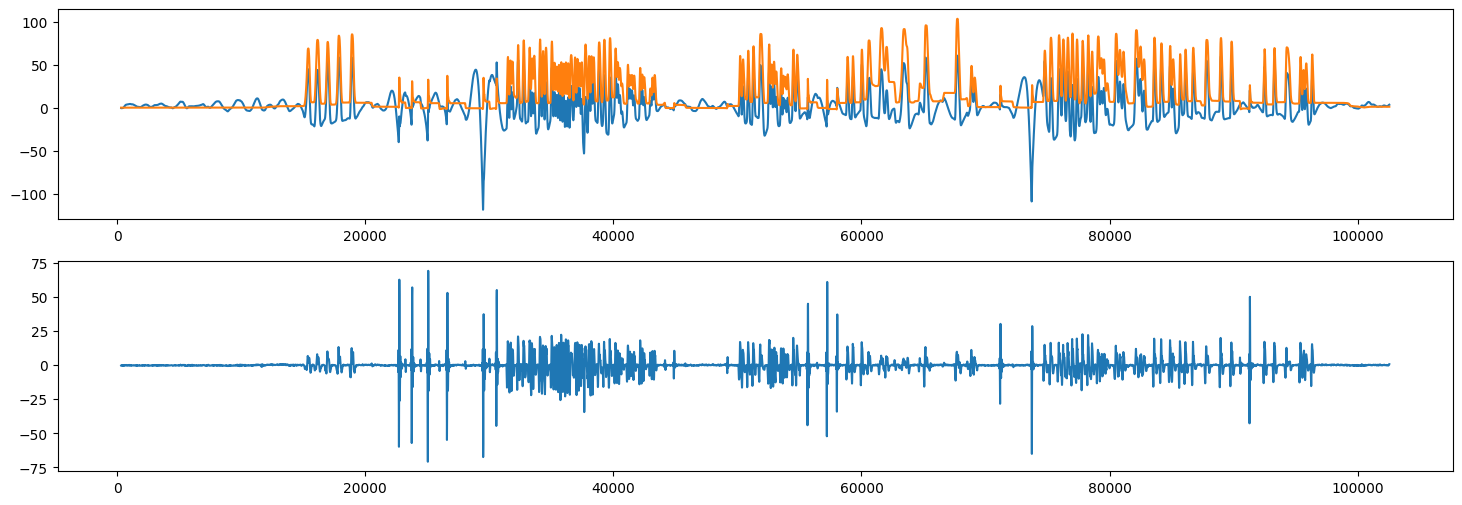

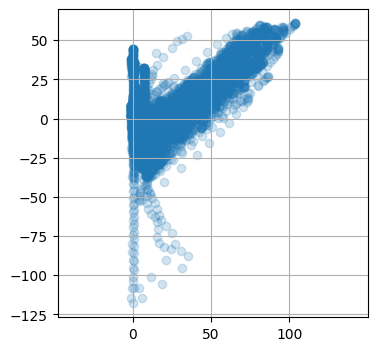

In [14]:
# Now mess with accel data
dt_s = np.diff(time, prepend=time[0]) / 1000.0

# broadcast to (S, T, A) and compute dv
dv = accel_proj * dt_s[:, None]
v = np.cumsum(dv, axis=0) * -1000

dx = v * dt_s[:, None]
x = np.cumsum(dx, axis=0)

# Lets try a HPF on velocity
fc_hz = 0.5
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="high", fs=fs, output="sos")

v_hp = sosfiltfilt(sos, v, axis=0)
dx_hp = v_hp * dt_s[:, None]
x_hp = np.cumsum(dx_hp, axis=0)


# Plot displacement vs travel
plt.figure(figsize=(18, 6))
plt.subplot(2, 1, 1)
plt.plot(time, x_hp[:, 0])
#plt.subplot(2, 1, 2)
plt.plot(time, travel)
# Plot accel vs time
plt.subplot(2, 1, 2)
plt.plot(time, accel_proj[:, 0])

plt.figure(figsize=(4, 4))
plt.scatter(travel, x_hp[:, 0], alpha=0.2)
plt.axis("equal")
plt.grid()

Crossing points: 136
59.762045559433375
Mag guess mean error 31.107494110400207
Actual mean error 13.430557263172263
RMSE before correction: 22.30522069989762, after 17.572515733110773


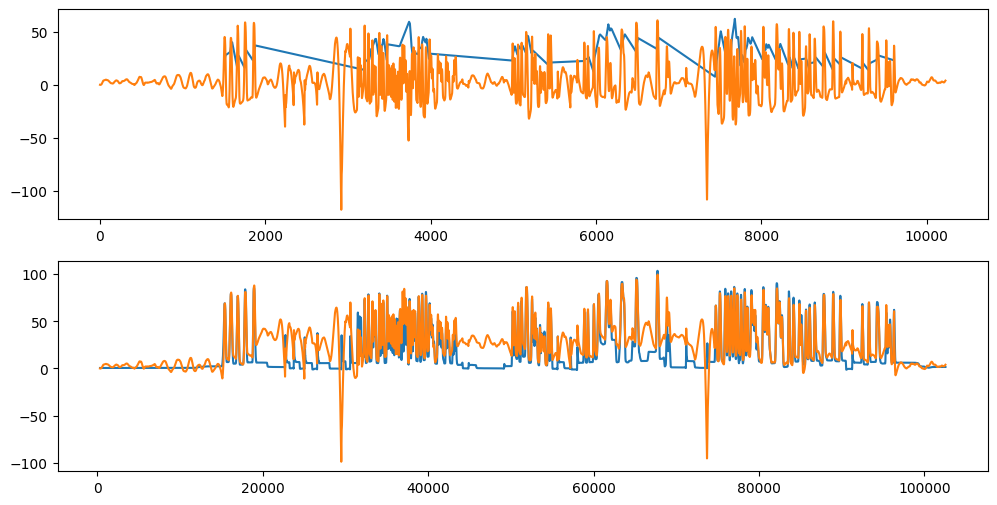

In [15]:
mag_crossing_thresh = 1500
s = mag_proj - mag_crossing_thresh
idx = np.nonzero((s[:-1] * s[1:]) < 0)[0]   # pairs (i, i+1) straddle

print(f"Crossing points: {len(idx)}")

# Predict travel at the threshold
mag_poly = poly.fit_transform(np.array(mag_crossing_thresh).reshape(1, -1))
travel_at_thresh = model.predict(mag_poly)[0]
print(travel_at_thresh)

# Get accelerometer predictions at the crossing points
acc_trav = x_hp[:, 0]
x_preds = (acc_trav[idx] + acc_trav[idx + 1]) / 2
errors = travel_at_thresh - x_preds
print("Mag guess mean error", np.mean(errors))
print("Actual mean error", np.mean(travel - acc_trav))

from scipy.interpolate import interp1d
# Create the error fit equation
f = interp1d(idx, errors, kind="linear", bounds_error=False, fill_value=np.nan)

error_time = f(time)

acc_trav_corr = np.copy(acc_trav)
for t_i in range(min(idx), max(idx)):
    acc_trav_corr[t_i] += f(t_i)

rmse = np.mean((acc_trav - travel) ** 2) ** 0.5
rmse_corr = np.mean((acc_trav_corr - travel) ** 2) ** 0.5
print(f"RMSE before correction: {rmse}, after {rmse_corr}")

# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, error_time)
plt.plot(acc_trav)
plt.subplot(2, 1, 2)
plt.plot(time, travel)
plt.plot(time, acc_trav_corr)
plt.show()
